In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
# Jiwer Library is required to evaluate the model, WER (Word Error Rate Calculation)
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.8 MB/s 
     |████████████████████████████████| 2.2 MB 44.5 MB/s 


In [ ]:
from jiwer import wer

# Dataset Preparation

### If you have the dataset downloaded then uncomment the below 2 cells

In [ ]:
# working_directory = '/content/drive/MyDrive/NLP Voice Recognition/Dataset/'
# !cd '/content/drive/MyDrive/NLP Voice Recognition/Dataset/'

In [ ]:
# datapath = working_directory + 'LJSpeech-1.1'

In [ ]:
# NOTE: Comment this cell if you have uncommented the above two.
dataurl = 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'
datapath = keras.utils.get_file('LJSpeech-1.1',dataurl,untar=True)

In [ ]:
# wavs directory contains the audio files and metadeta file contains transcription and filenames
wavs_path = datapath + "/wavs/"
metadata_path = datapath + "/metadata.csv"

In [ ]:
# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ013-0216,His account of his acts and movements after th...
1,LJ028-0192,"When the news came to the Hebrews, who were he..."
2,LJ030-0126,"According to plan, the President's motorcade p..."


In [ ]:
# Split the dataset into training and validation sets. 90/10.
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


# Data Preprocessing

In [ ]:
# The window length in samples.
frame_length = 256
# The number of samples to step.
frame_step = 160
# The size of the FFT to apply.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label


In [ ]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


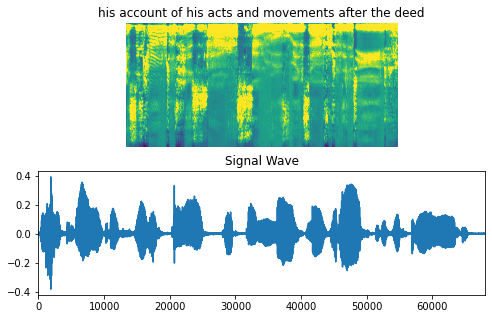

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [ ]:

def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


# Define Model Architecture

In [ ]:

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


# Model Training

### NOTE: For GPU Limitation, we trained the model in multiple steps and saved model after each epoch.
### To avoid errors, or timeouts we ran each epoch separately

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : who kept a lavender warehouse in the city and who had gardens at feltham
Prediction: sn
----------------------------------------------------------------------------------------------------
Target    : and twelve nineteen sixtythree and most probably on either march nine or march ten
Prediction: ss
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 5520s 15s/step - loss: 300.0269 - val_loss: 251.7714


In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

1/1 [==============================] - 1s 540ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.8834
----------------------------------------------------------------------------------------------------
Target    : in particular the commission believes that the motorcade route selected by agent lawson upon the advice of agent in charge sorrels
Prediction: inbertoer the comiion bls that the moterc r solit te bon loson o pon the  bioften in cr sr
----------------------------------------------------------------------------------------------------
Target    : the chronicles of newgate volume two by arthur griffiths section fifteen newgate notorieties part three
Prediction: the conls of nb to vt b or ther riffi sionfin nb notheritis prfr
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 1329s 4s/step - loss: 200.4733 - val_

In [ ]:
model.save('/content/drive/MyDrive/NLP Voice Recognition/saved_model/my_model.h5')

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

1/1 [==============================] - 1s 540ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.7879
----------------------------------------------------------------------------------------------------
Target    : to them entered the chaplain or ordinary of newgate in full canonicals
Prediction: so tham a anter the caporn or or nary of merga infl cenoncols
----------------------------------------------------------------------------------------------------
Target    : with small groups of those truly representative of large employers of labor and of large groups of organized labor
Prediction: wit smal ero sof tho s trly repers attto o a lar erplors of lyber and of lar gris o or ni lyr
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 1380s 4s/step - loss: 139.2592 - val_loss: 111.3817


In [ ]:
model.save('/content/drive/MyDrive/NLP Voice Recognition/saved_model/my_model.h5')

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

1/1 [==============================] - 1s 543ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6982
----------------------------------------------------------------------------------------------------
Target    : it would be far better to begin at the beginning
Prediction: it wald be far beter to be den at the begening
----------------------------------------------------------------------------------------------------
Target    : he became a militia officer and married a woman with ten thousand pounds in which however she had only a life interest
Prediction: he becamammolisal officer ad mary a ommen with tem tosan pounds in wich hoever he had only a life antres
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 1321s 4s/step - loss: 111.4269 - val_loss: 90.9294


In [ ]:
model.save('/content/drive/MyDrive/NLP Voice Recognition/saved_model/my_model.h5')

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

1/1 [==============================] - 1s 541ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6205
----------------------------------------------------------------------------------------------------
Target    : cole found out where they were and redeemed them at a heavy outlay thus obtaining business relations with the firm that held them
Prediction: col found ut were the wer and bredeen them at a havvy outlay bus utaning visnesrelations with the firm that hel then
----------------------------------------------------------------------------------------------------
Target    : we are now prepared to move into this second phase on the basis of our experience in the first phase
Prediction: we ar not prpar to movento the seckinfas on the bas a orexperans an tevers fae
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 1

In [ ]:
model.save('/content/drive/MyDrive/NLP Voice Recognition/saved_model/my_model1.h5')

# Model Evaluation And Predictions

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 [==============================] - 1s 535ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6205
----------------------------------------------------------------------------------------------------
Target    : the aged but wary kerp the moment the plot was discovered vanished and was never more heard of
Prediction: the aged but wary cur the mobet the plot was descoverd banish and was never morherdo
----------------------------------------------------------------------------------------------------
Target    : would be the first to exclaim as soon as an amendment was proposed
Prediction: would bee firs to xclan a so is an emendment was prepose
----------------------------------------------------------------------------------------------------
Target    : in which the master evil of jail association and consequent contamination still continues to operate directly to the encouragement of crime
Prediction: in 

# Further Training on next day loading saved model.

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/NLP Voice Recognition/saved_model/my_model1.h5', custom_objects={'CTCLoss': CTCLoss})
# model = load_model('/content/drive/MyDrive/NLP Voice Recognition/saved_model/my_model1.h5')

In [ ]:
for i in range(2,8):
  # Define the number of epochs.
  epochs = 1
  # Callback function to check transcription on the val set.
  validation_callback = CallbackEval(validation_dataset)
  # Train the model
  history = model.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=epochs,
      callbacks=[validation_callback],
  )

  model.save(f'/content/drive/MyDrive/NLP Voice Recognition/saved_model/my_model{i}.h5')


1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.5443
----------------------------------------------------------------------------------------------------
Target    : were found in the butler's pantry used by courvoisier
Prediction: er found in the buclers pantry use by cervusia
----------------------------------------------------------------------------------------------------
Target    : when paul m stombaugh of the fbi laboratory examined the paper bag
Prediction: when pal am sto ba of the fbea labertory axamind the paer ba
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 1s 594ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.5089
-------------------------------------------------------------------

In [ ]:
for i in range(6,12):
  # Define the number of epochs.
  epochs = 1
  # Callback function to check transcription on the val set.
  validation_callback = CallbackEval(validation_dataset)
  # Train the model
  history = model.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=epochs,
      callbacks=[validation_callback],
  )

  model.save(f'/content/drive/MyDrive/NLP Voice Recognition/saved_model/my_model{i}.h5')


##### NOTE: WORD ERROR RATE AND VALIDATION LOSS CAN BE SEEN AFTER EVERY EPOCH. PLOTS ARE NOT GIVEN BECAUSE OF RUNTIME RECONNECT AND WE LOST THE HISTORY RESULTS.

###### RECOMMENDATIONS: AS THE MODEL TRAINING IS NOT COMPLETED AND ONLY 10 EPOCHS HAVE BEEN COMPLETED SO FAR, SO FURTHER 30 TO 40 EPOCHS CAN BE EXECUTED TO GET FINAL RESULTS. RECOMMENDED EPOCHS ARE 50.